## __Step 2, Variant 1:__ Heuristic Droplet Matrix Filtering

The goal of Step 2 is to determine which barcodes within the droplet matrix contain high quality transcriptomic information. This droplet matrix is then filtered to produce a cell matrix, containing only those high quality barcodes.

---
### __2v1.1-3__ Converting dropEst output and inflection point estimation

First we need to import the python libraries and functions to use in this part of the pipeline.

In [1]:
import QCPipe #Contains functions required for the QC portion of this pipeline
import scanpy as sc
import numpy as np

In [2]:
sc.set_figure_params(dpi=200) #Set figure size to 200 dpi for legibility
sc.settings.verbosity = 3 #Set scanpy verbosity to 3 for in depth function run information

In [3]:
import random
random.seed(56)

Next we import the droplet matrix, gene list, and barcode list as an AnnData function with the QCPipe function, read_dropest.

In [5]:
adata = QCPipe.qc.read_dropest("Unfiltered_TNP_Data.h5ad") #This should just be the path to the directory in which those 3 output files are contained.

It's helpful to save this droplet matrix as .h5ad file with compression to save on storage space and convenience for the next time we want to read files.

In [4]:
adata.write_h5ad("Unfiltered_TNP_Data.h5ad",compression='gzip')

In [4]:
#adata = sc.read_h5ad("Unfiltered_TNP_Data.h5ad")

An effective first pass filter is to use inflection point estimation to determine a set of the highest quality barcodes in the full library.

Calculating QC Metrics
Inflection point at [20549 38670 56792] for [0, 15, 30] percentiles of greatest secant distances


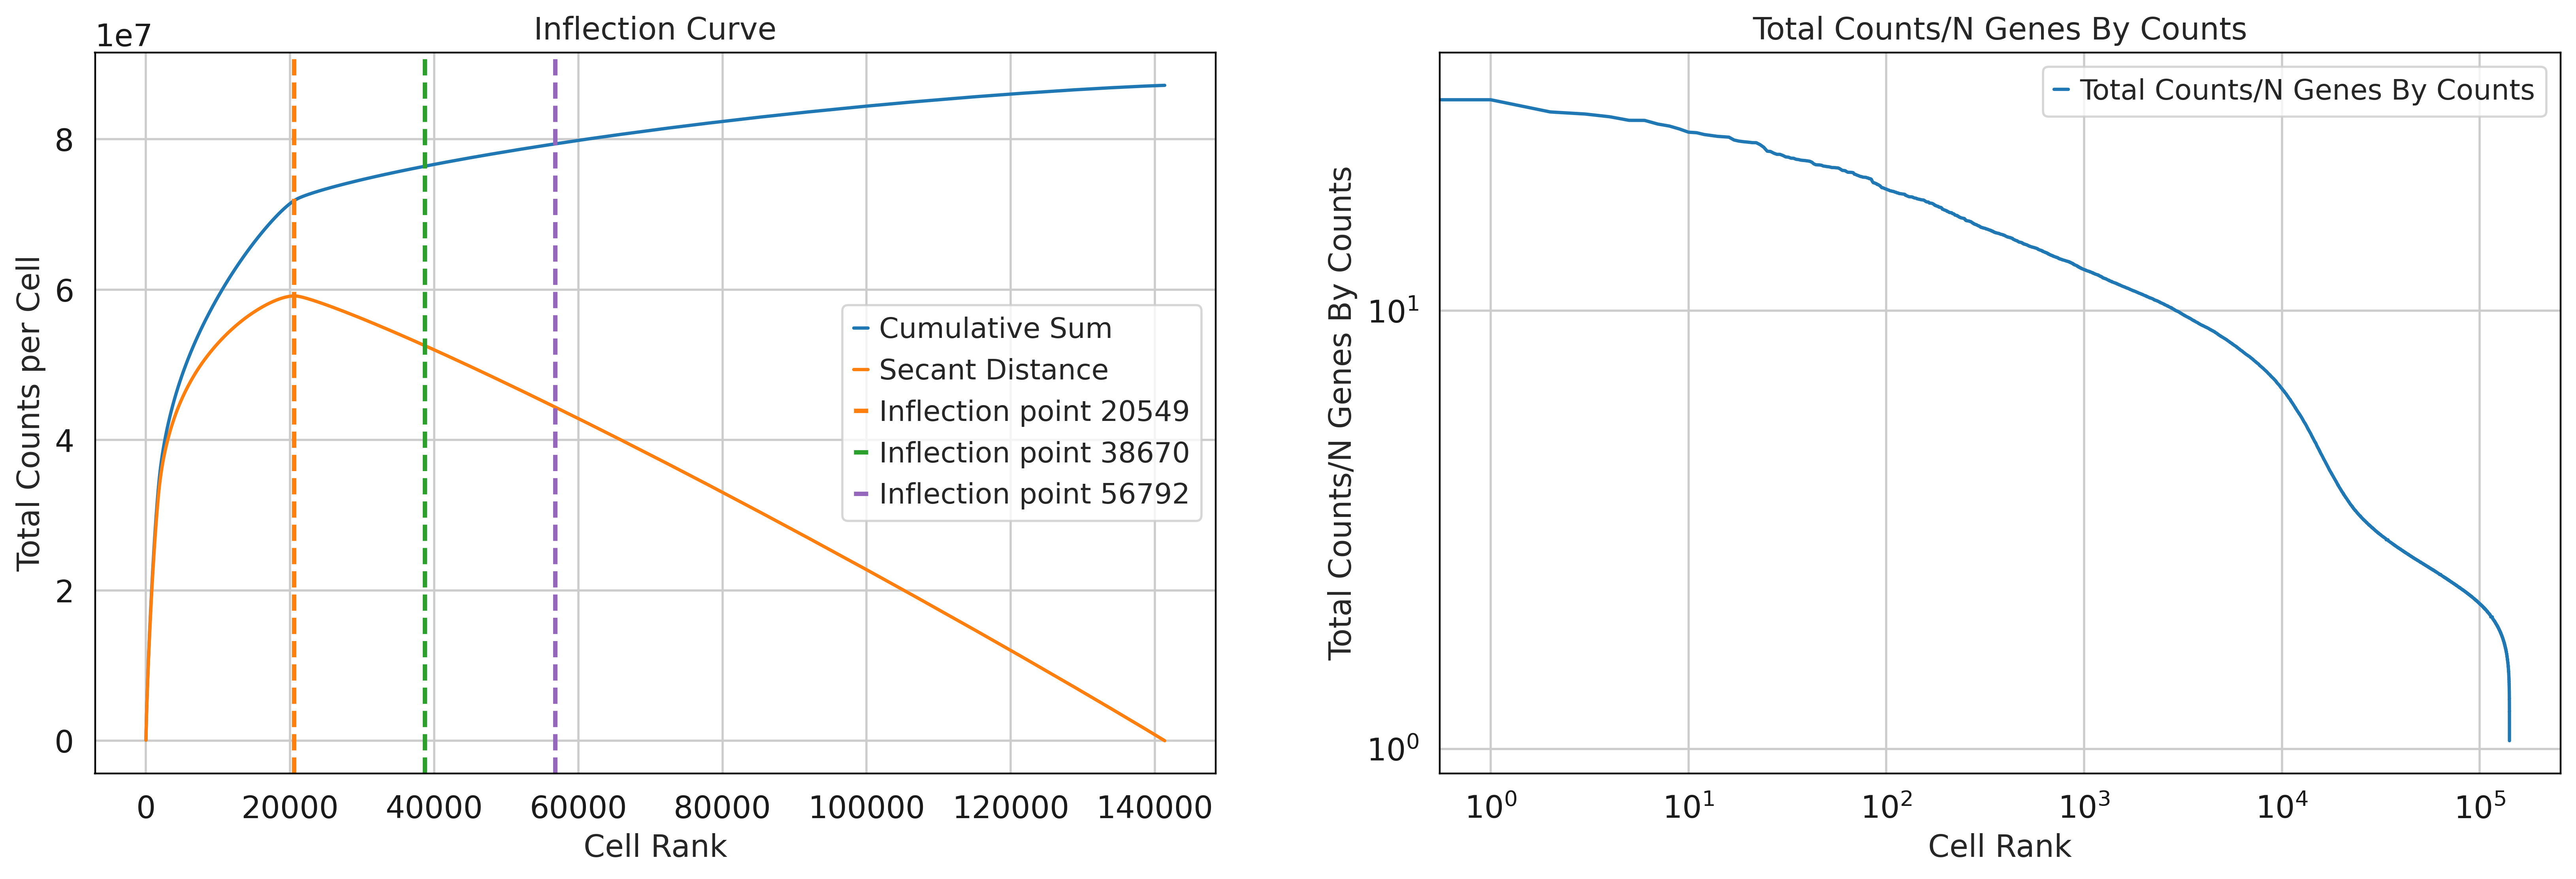

In [5]:
inf = QCPipe.qc.find_inflection(adata)

After estimating this inflection point and storing it in the variable 'inf' we use that point to subset our data based on that determined minimum quality threshold. This inflection point estimation function also calculates several generic quality control metrics for the dataset. This is seen when printing the contents of 'adata', and the 'obs' attribute is shown to contain information like 'n_genes_by_counts'

In [6]:
sc.pp.filter_cells(adata,min_counts=adata[inf[0]].obs.total_counts[0])

filtered out 120809 cells that have less than 619.0 counts


/home/bob/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [7]:
adata

AnnData object with n_obs × n_vars = 20553 × 29426
    obs: 'total_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_Mitochondrial', 'log1p_total_counts_Mitochondrial', 'pct_counts_Mitochondrial', 'n_counts'
    var: 'Mitochondrial', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'Order'

---
### __2v1.4__ Relative transcript diversity determination 

Transcript diversity is useful in determining the amount of informative transcript reads contained within a droplet. The distribution of this metric, being the number of unique genes detected in a single droplet, is typically multimodal in a high quality dataset. Here, we automatically determine this threshold and label each individual droplet as such, being of high or low transcript diversity.

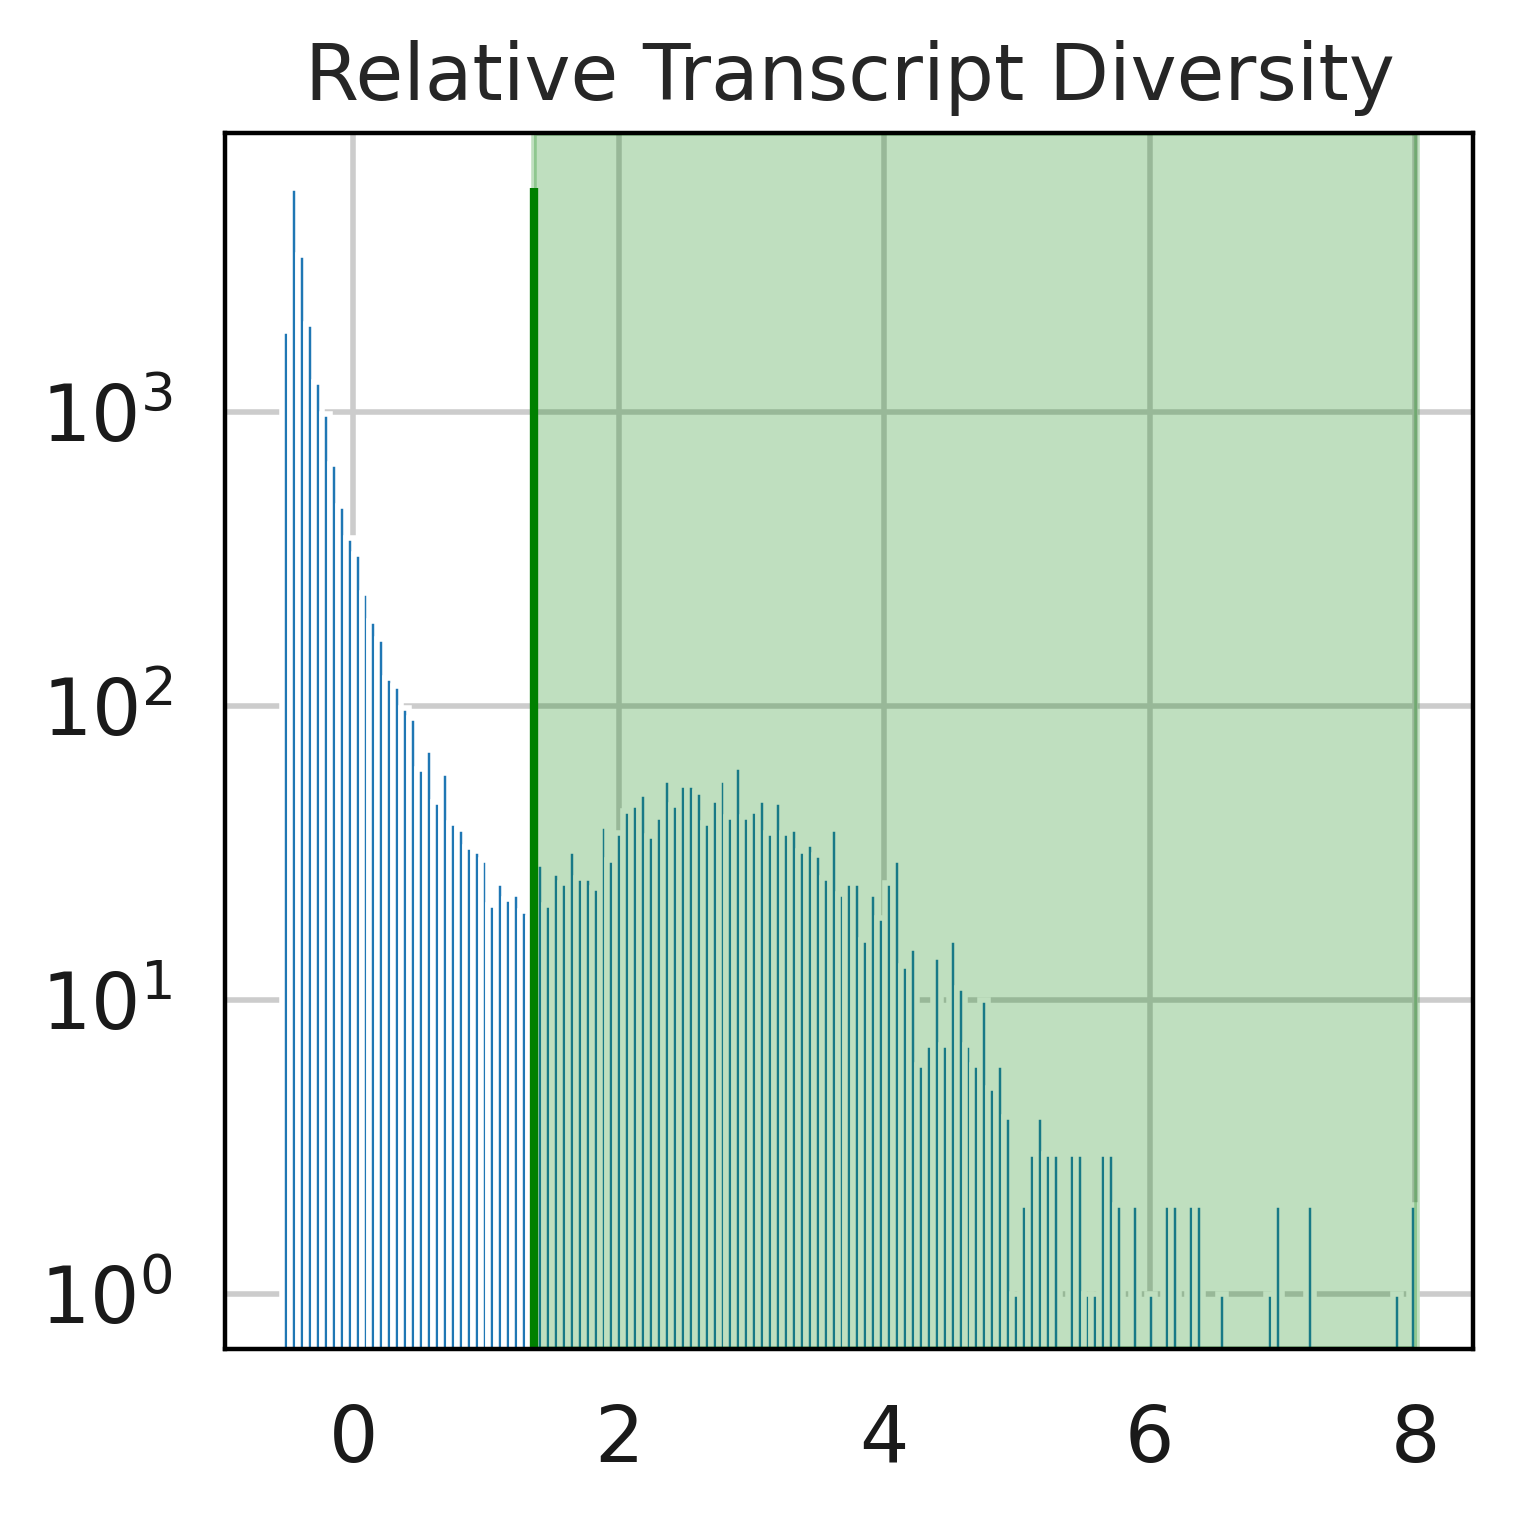

In [8]:
adata = QCPipe.qc.relative_diversity(adata)

---
### __2v1.5-7__ Droplet matrix normalization, dimensionality reduction, and unsupervised clustering

In order to visualize and perform further analyses on this droplet matrix, we must normalize the data first.

In [9]:
sc.pp.normalize_total(adata) #Normalize data by the median counts per single cell library
adata.X = np.arcsinh(adata.X).copy() #Transform the data by using an inverse hyperbolic sine transform, this eliminates the need for adding a pseudocount 
sc.pp.scale(adata) #Scale and center the data for interpretability

normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


The data should then be linearly decomposed with PCA, to aid in its downstream processing.

In [10]:
sc.pp.pca(adata,random_state=0) 

computing PCA
    with n_comps=50
    finished (0:01:12)


Next, the a KNN needs to be generated. This graphical representation is used in the determination of Leiden communities and non-linear dimension reduction such as UMAP.

In [11]:
neighborhood_k = np.sqrt(adata.n_obs).astype(int) #We have found that scaling the K to equal the square root of the total number of neighbors to be effective
sc.pp.neighbors(adata,n_neighbors=neighborhood_k,use_rep='X_pca',random_state=0) #Calculate this KNN based off of the PCA distances

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:15)


The KNN calculation and the following UMAP calculation can be fairly time consuming, so it is suggested that the 2 dimensional UMAP coordinates are saved to file if the user wishes to halt analyses and continue later.

In [12]:
sc.tl.umap(adata,min_dist=0.25,random_state=0)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:20)


In [13]:
#pd.DataFrame(adata.obsm['X_umap']).to_csv("X_umap.csv") #This saves the UMAP coordinates to a .csv file
#adata.obsm['X_umap'] = pd.read_csv("X_umap.csv",index_col=0).values #This reads the UMAP coordinates from the above .csv file

Now we perform the Leiden community detection algorithm on the determined KNN as a way to segment the droplets in a data-driven way. This makes it easier for us to select specific, high quality cells contained in droplets in downstream steps.

In [14]:
sc.tl.leiden(adata,resolution=2,random_state=0) #Here we use a resolution of 2, which should yield 30+ clusters. This step may take a while.

running Leiden clustering
    finished: found 33 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:01:29)


Finally, we visualize all these information together for the subsequent heuristic cluster selection steps. First we visualize normalized gene expression values over the 2 dimensional UMAP. These genes are tailored, from literature review, to be representative of known subpopulations within the colonic epithelium.

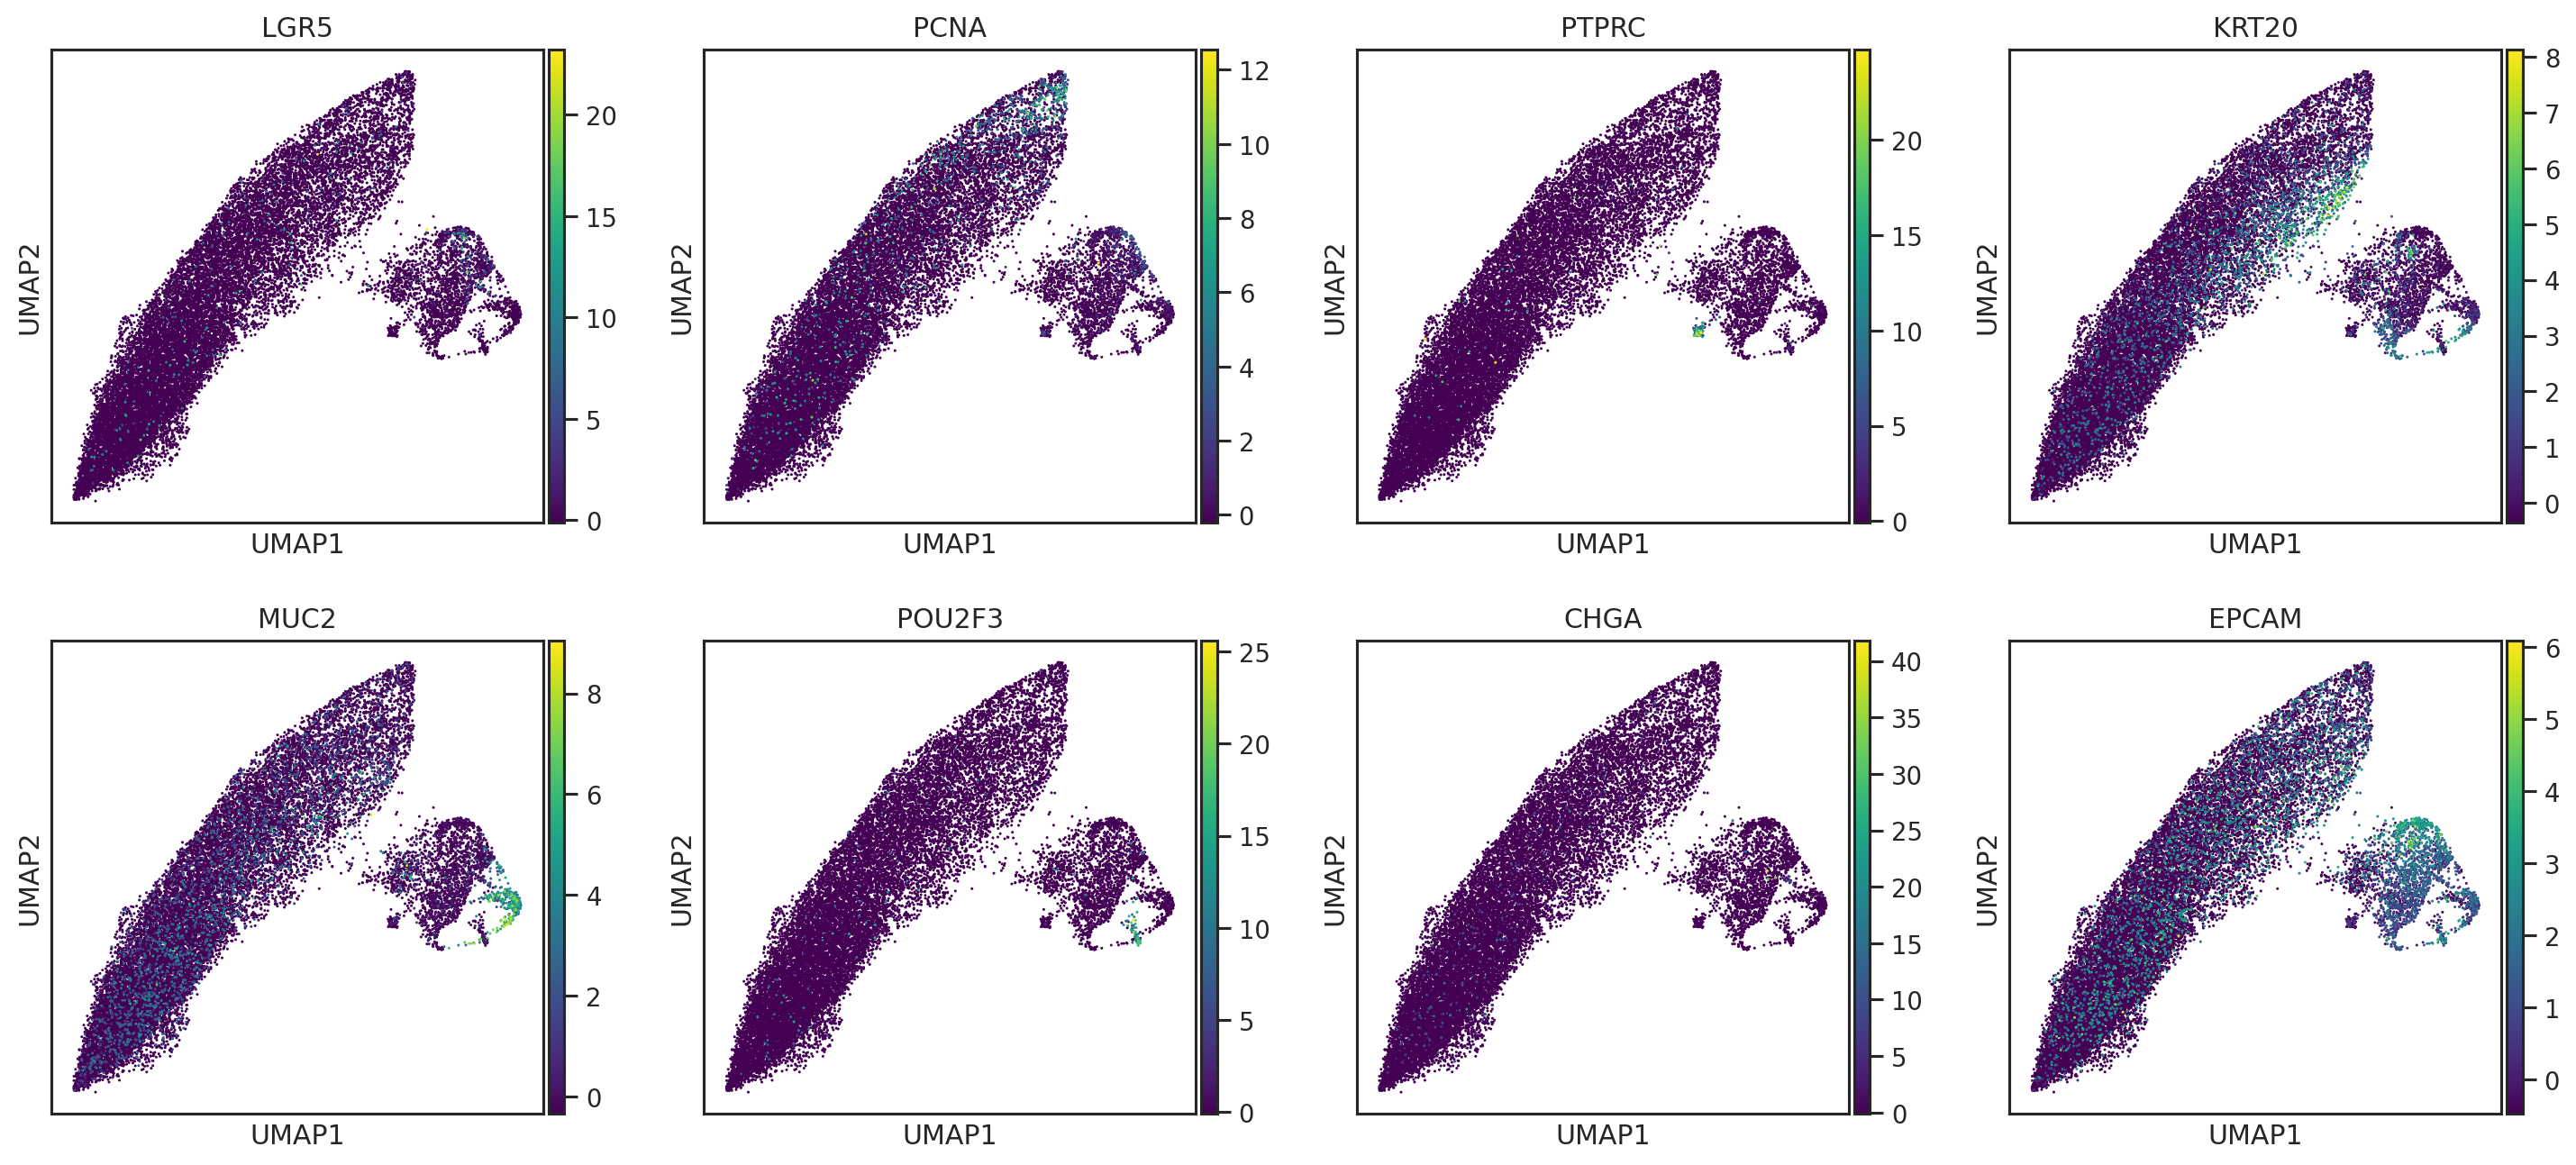

In [24]:
sc.pl.umap(adata,color=['LGR5','PCNA','PTPRC','KRT20','MUC2','POU2F3','CHGA','EPCAM'],use_raw=False,cmap='viridis')

Second, we visualize our calculated QC metrics as well as defined cells which surpassed our automatically determined relative transcript diversity threshold beside our Leiden clusters. 

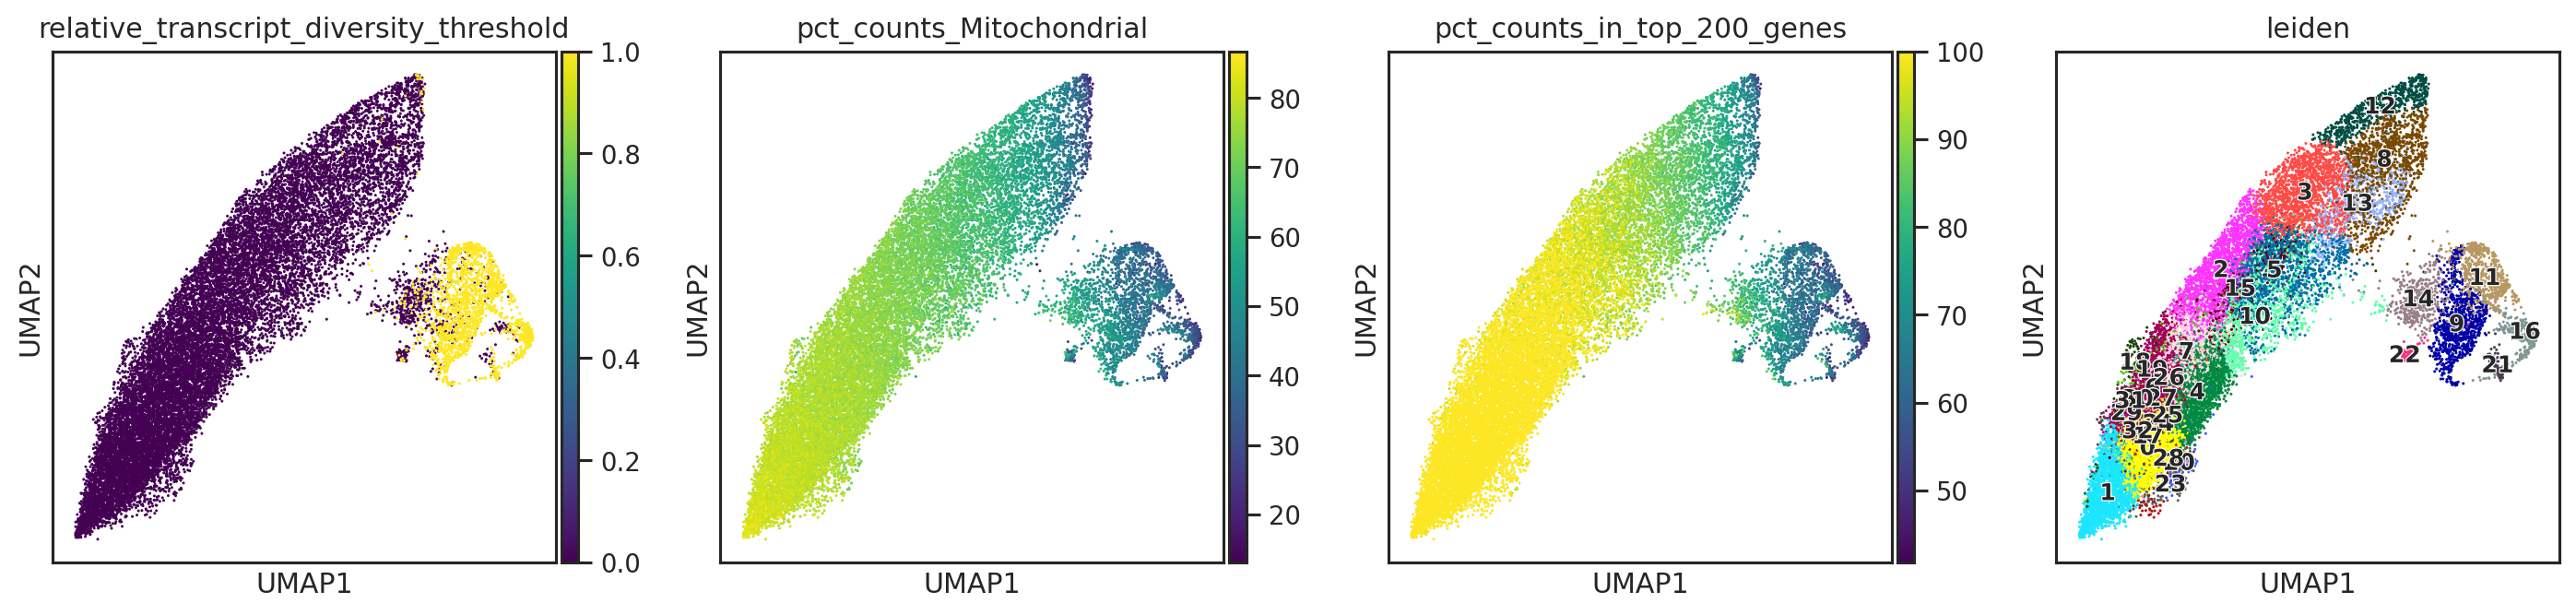

In [27]:
sc.pl.umap(adata,color=['relative_transcript_diversity_threshold','pct_counts_Mitochondrial','pct_counts_in_top_200_genes','leiden'],legend_loc='on data',legend_fontoutline=True,legend_fontsize=10,cmap='viridis')

---
### __2v1.8__ Heuristic droplet filtering and the selection of high quality cells

Given these observed metric and gene signature enrichments, we select the following clusters as high quality cells.

In [28]:
selected_clusters = ['11','9','22','21','16']

In [31]:
adata.obs['Cell_Selection'] = np.isin(adata.obs['leiden'],selected_clusters).astype(bool) 
#An observation vector can be set in our AnnData object for easy visualization

Now we can do a final check on the clusters which we are interested in subsetting and carrying forward by visualizing the "Cell_Selection" that we set previously.

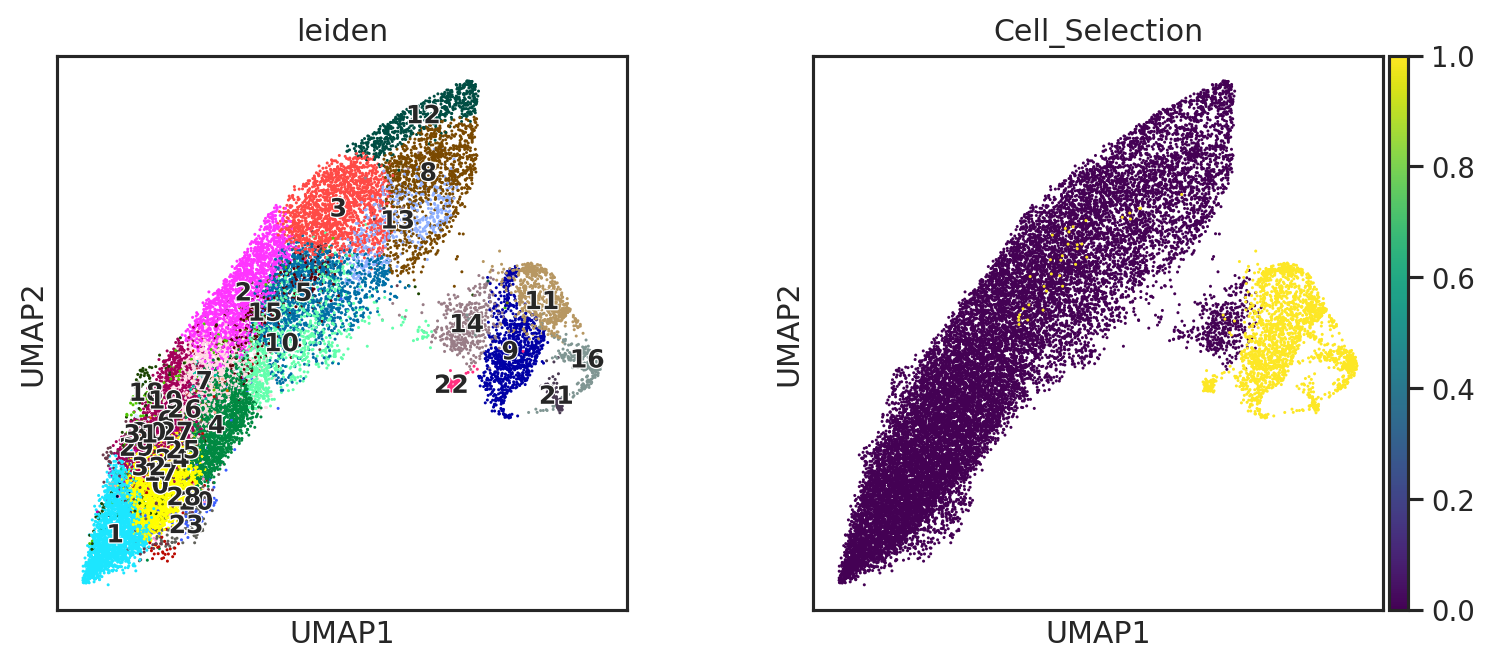

In [35]:
sc.pl.umap(adata,color=['leiden','Cell_Selection'],legend_loc='on data',legend_fontoutline=True,legend_fontsize=10,cmap='viridis')

---
### __2v1.9__ Cell matrix generation through subsetting droplet matrix 

These selected clusters can now be used to subset the data such that we generate a cell matrix with raw counts that can be used as an entry point for downstream scRNA-seq analyses, such as those laid out in Step 3 of this protocol

In [ ]:
data_out = QCPipe.qc.subset_cleanup(adata,selection='Cell_Selection')

In [47]:
data_out

AnnData object with n_obs × n_vars = 2176 × 29426

In [ ]:
data_out.write_h5ad("Filtered_TNP_Data.h5ad",compression='gzip')